In [ ]:
import numpy as np
from numba.typed import List as NumbaList
from BPnumba.NumAG import CalcFi,create_intidivual,Ind
from BPnumba.GeneticOperators import InstancePob,CreatePoblation,CreatePermutation,RouletteWheel

from BPmodule.BPGen  import PROBLEM2,PROBLEM3,PROBLEM4,PROBLEM5
from numba import njit
from typing import List
import random

In [ ]:
P2A1 = PROBLEM2[0]
P2A2 = PROBLEM2[1]
P3A1 = PROBLEM3[0]
P3A2 = PROBLEM3[1]
P4A1 = PROBLEM4[0]
P4A2 = PROBLEM4[1]
P5A1 = PROBLEM5[0]
P5A2 = PROBLEM5[1]

In [ ]:
@njit
def ImproveB(i:int,ColonyWorker:List[Ind],n:int)->List[int]:
    k = random.randint(0,n-1)
    j = random.randint(0,len(ColonyWorker)-1)
    while i == j:
        j = random.randint(0,len(ColonyWorker)-1)
    beeK = ColonyWorker[j]
    vik = abs(round(ColonyWorker[i].genome[k] + random.uniform(-1,1)*(ColonyWorker[i].genome[k]-beeK.genome[k])))
    if vik > n:
        vik=n
    elif vik<1:
        vik=1
    original = ColonyWorker[i].genome.copy()
    prev = original[k]
    original[k] = vik
    for l in np.arange(n):
        if l != k and original[l]==vik:
            original[l]=prev
            break
    return original
@njit
def CreateRandomSoltion(n:int,boxes:List[List[int]],container:List[int])->Ind:
    xmin =1
    xmax= n 
    visited = [ False for i in np.arange(n+1)]
    newcode = np.zeros(n,dtype=np.int64)
    for i in np.arange(n):
        xj = round(xmin + random.uniform(0,1)*(xmax-1))
        if xj <= xmin:
            xj=xmin
            xmin +=1
        elif xj>= xmax:
            xj=xmax
            xmax -=1
        while visited[xj]:
            xj = round(xmin + random.uniform(0,1)*(xmax-1))
            if xj <= xmin:
                xj=xmin
                xmin +=1
            elif xj>= xmax:
                xj=xmax
                xmax -=1
        newcode[i] = xj
        visited[xj]=True   
    nwbee = create_intidivual(NumbaList(newcode))
    CalcFi(nwbee,boxes,container)
    return nwbee

In [ ]:
@njit
def ABCTrain(numItr:int,ColonyWorker:List[Ind],n:int,datos,contenedor,register:List[float])->Ind:
    fail = np.zeros(len(ColonyWorker))
    Limit = (len(ColonyWorker)-1)*n*100
    bestBee=ColonyWorker[0]
    maxIdex=0
    maxFail = 0
    for _ in np.arange(numItr):
    #Busqueda local de abejas para todas las trabajadoras y calcila Pi
        for i in np.arange(len(ColonyWorker)):
            b2gen=ImproveB(i,ColonyWorker,n)
            nwbee = create_intidivual(b2gen)
            CalcFi(nwbee,datos,contenedor)
            if nwbee.fi > ColonyWorker[i].fi:
                ColonyWorker[i]=nwbee
                fail[i]=0
                if maxIdex == i:
                    maxFail=0
            else:
                fail[i]+=1
                if fail[i]>maxFail:
                    maxFail=fail[i]
                    maxIdex=i
            if bestBee.fi < ColonyWorker[i].fi:
                bestBee=ColonyWorker[i]
        #Busqueda Onlooker bee
        for i in np.arange(len(ColonyWorker)):
            j = RouletteWheel(ColonyWorker)
            b2gen=ImproveB(j,ColonyWorker,n)
            nwbee = create_intidivual(b2gen)
            CalcFi(nwbee,datos,contenedor)
            if nwbee.fi > ColonyWorker[j].fi:
                ColonyWorker[j]=nwbee
                fail[j]=0
                if maxIdex == i:
                    maxFail=0
            else:
                fail[j]+=1
                if fail[i]>maxFail:
                    maxFail=fail[i]
                    maxIdex=i
            if bestBee.fi < ColonyWorker[i].fi:
                bestBee=ColonyWorker[i]
        if maxFail>=Limit:
            ColonyWorker[maxIdex] = CreateRandomSoltion(n,datos,contenedor)
            maxFail=0
            fail[maxIdex]=0
        register[_]=bestBee.fi
        if bestBee.fi==1:
            return bestBee
    return bestBee

In [ ]:
contenedor =np.asanyarray( P3A2[0],dtype=np.int64)
datos =np.asanyarray(P3A2[1],dtype=np.int64)
idBoxes = np.arange(1,len(datos)+1,dtype=np.int64)
n=len(datos)


In [ ]:
numItr = 4
bestBeesFi = np.zeros(numItr,dtype=np.float64)
comGen=CreatePoblation(2,idBoxes)
comPob= InstancePob(comGen,datos,contenedor)
ABCTrain(numItr,comPob,n,datos,contenedor,bestBeesFi)
print('compiled InstancePob')

In [41]:
poblation = CreatePoblation(26,idBoxes)
ColonyWorker = InstancePob(poblation,datos,contenedor)
numItr = 500
bestBeesFi = np.zeros(numItr,dtype=np.float64)

In [42]:
bee =ABCTrain(numItr,ColonyWorker,n,datos,contenedor,bestBeesFi)

In [43]:
bee.fi

0.981244

In [44]:
import matplotlib.pyplot as plt

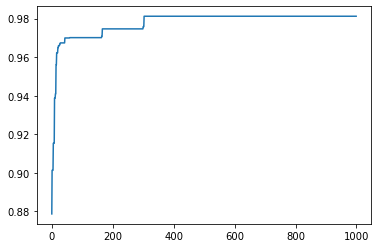

In [45]:
plt.figure()
plt.plot(bestBeesFi)
plt.show()